In [2]:
import random
import matplotlib.pyplot as plt

from typing import List
from collections import deque, defaultdict

random.seed(42)

class ReservoirList:
    def __init__(self) -> None:
        self.data = deque()
        self.len = 0
        self.stats_value_to_samplecount = defaultdict(int)

    def insert(self, value):
        self.len += 1
        if random.randint(0, self.len - 1) == 0:
            self.data.appendleft(value)
        else:
            self.data.append(value)

    def insert_back(self, value):
        self.len += 1
        self.data.append(value)

    def sample(self, n):
        n = min(n, self.len)
        res = []
        for _ in range(n):
            elem = self.data.popleft()
            res.append(elem)
            self.len -= 1
        return res

    def sample_with_reinsertion(self, n):
        n = min(n, self.len)
        values_sampled = []
        for _ in range(n):
            value = self.data.popleft()
            values_sampled.append(value)
            self.len -= 1
            self.stats_value_to_samplecount[value] += 1
        # Assume reinsertion for now
        for value in values_sampled:
            self.insert(value)

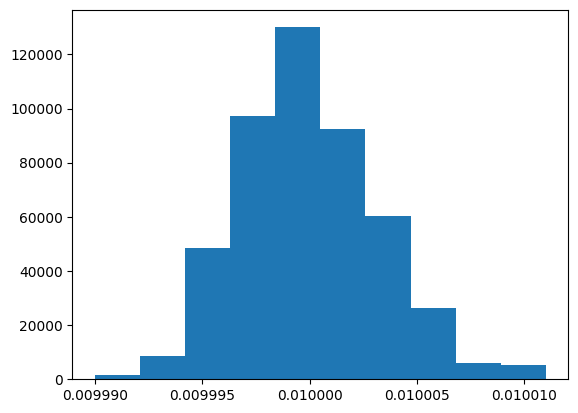

In [3]:
keys = range(1000)
num_iterations = 1000000
sample_size = 10

l = ReservoirList()
for key in keys:
    l.insert(key)
for _ in range(num_iterations):
    l.sample_with_reinsertion(sample_size)

# Print stats
count_dist = []
for key in keys:
    normalized_count = l.stats_value_to_samplecount[key] / num_iterations
    count_dist.append(normalized_count)
_ = plt.hist(count_dist, bins=10, density=True)

In [4]:
import abc
import time
from typing import List
from collections import deque


class CacheAlgorithm(abc.ABC):

    @abc.abstractmethod
    def name(self):
        pass

    @abc.abstractmethod
    def insert(self, key):
        pass

    @abc.abstractmethod
    def key_exists(self, key):
        pass

    @abc.abstractmethod
    def evict(self):
        pass


class MRU(CacheAlgorithm):
    def __init__(self) -> None:
        self.data = deque()
        self.keys_in_cache = set()

    def name(self):
        return "MRU"

    def insert(self, key):
        self.data.appendleft(key)
        self.keys_in_cache.add(key)

    def evict(self):
        res = self.data.popleft()
        self.keys_in_cache.remove(res)
        return res

    def key_exists(self, key):
        # if key in self.keys_in_cache:
        #     self.data.remove(key)
        #     self.data.appendleft(key)
        return key in self.keys_in_cache


class SamplingMRU(CacheAlgorithm):
    def __init__(self, sample_size) -> None:
        self.data = ReservoirList()
        self.sample_size = sample_size
        self.key_to_last_access_time = {}

    def name(self):
        return f"SamplingMRU({self.sample_size})"

    def insert(self, key):
        self.key_to_last_access_time[key] = time.time()
        self.data.insert(key)

    def evict(self):
        samples = self.data.sample(self.sample_size)
        samples.sort(key=lambda x: self.key_to_last_access_time[x], reverse=True)
        res = samples[0]
        del self.key_to_last_access_time[res]
        for key in samples[1:]:
            self.data.insert_back(key)
        return res

    def key_exists(self, key):
        if key in self.key_to_last_access_time:
            self.key_to_last_access_time[key] = time.time()
        return key in self.key_to_last_access_time


class CacheSimulation:
    def __init__(self, max_cache_size) -> None:
        self.max_cache_size = max_cache_size

    def run(self, trace: List[int], cache_algorithm: CacheAlgorithm):
        curr_cache_size = 0
        stats = RunStats()
        print(
            f"Running simulation with {len(trace)} keys, max_cache_size={self.max_cache_size}, algorithm={cache_algorithm.name()}"
        )
        for key in trace:
            if cache_algorithm.key_exists(key):
                stats.hit()
            else:
                stats.miss()
                # Cache not full yet
                if curr_cache_size < self.max_cache_size:
                    cache_algorithm.insert(key)
                    curr_cache_size += 1
                else:
                    _ = cache_algorithm.evict()
                    curr_cache_size -= 1
        stats.print_summary()
        return stats


class RunStats:
    def __init__(self) -> None:
        self.hit_count = 0
        self.miss_count = 0

    def hit(self):
        self.hit_count += 1

    def miss(self):
        self.miss_count += 1

    def print_summary(self):
        print(f"Hit count: {self.hit_count}, miss count: {self.miss_count}, hit rate: {self.hit_count / (self.hit_count + self.miss_count):.2f}")

In [10]:
def create_scan_trace(num_iterations=4):
    number_of_keys = int((1288490188) // (4*2**10))
    trace = []
    for _ in range(num_iterations):
        trace.extend(range(number_of_keys))
    return trace

max_cache_size = int(0.82 * 1288490188 // (4*2**10))
mru = MRU()
sampling_mru_5 = SamplingMRU(4)
sampling_mru_10 = SamplingMRU(8)
sampling_mru_16 = SamplingMRU(16)
sampling_mru_32 = SamplingMRU(32)
sampling_mru_64 = SamplingMRU(64)

sampling_algorithms = [SamplingMRU(i) for i in [2, 4, 6, 8, 10, 12, 14, 16, 32, 64]]
cache_algorithms = [mru] + sampling_algorithms
cache_sim = CacheSimulation(max_cache_size)
trace = create_scan_trace(num_iterations=4)

for cache_algorithm in cache_algorithms:
    start_time = time.time()
    cache_sim.run(trace, cache_algorithm)
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

Running simulation with 1258288 keys, max_cache_size=257949, algorithm=MRU
Hit count: 773844, miss count: 484444, hit rate: 0.61
Time taken: 0.35 seconds
Running simulation with 1258288 keys, max_cache_size=257949, algorithm=SamplingMRU(2)
Hit count: 694417, miss count: 563871, hit rate: 0.55
Time taken: 0.97 seconds
Running simulation with 1258288 keys, max_cache_size=257949, algorithm=SamplingMRU(4)
Hit count: 714604, miss count: 543684, hit rate: 0.57
Time taken: 1.12 seconds
Running simulation with 1258288 keys, max_cache_size=257949, algorithm=SamplingMRU(6)
Hit count: 741515, miss count: 516773, hit rate: 0.59
Time taken: 1.11 seconds
Running simulation with 1258288 keys, max_cache_size=257949, algorithm=SamplingMRU(8)
Hit count: 764999, miss count: 493289, hit rate: 0.61
Time taken: 1.20 seconds
Running simulation with 1258288 keys, max_cache_size=257949, algorithm=SamplingMRU(10)
Hit count: 744908, miss count: 513380, hit rate: 0.59
Time taken: 1.57 seconds
Running simulation w